  0%|          | 0/250 [00:00<?, ?it/s]

#samples:        torch.Size([1000, 2])
Are the classes balanced?
#true_samples:   torch.Size([485, 2])
#false_samples:  torch.Size([515, 2])
Baseline accuracy: 99.4 %
Targets converted to one-hot


100%|██████████| 250/250 [00:02<00:00, 97.09it/s] 


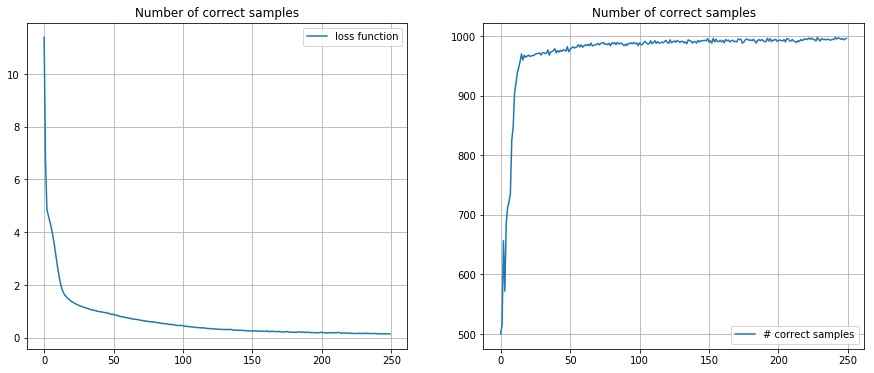

In [8]:
from torch import Tensor
from torch import optim
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch import nn
import torch
from tqdm import trange

# imports from this same folder
import loadData
import baseline
import trainAndTest


# Generate data with target 0 if outside the circle or 1 if inside
train_input, train_target = loadData.generate_disc_set(1000)
test_input, test_target = loadData.generate_disc_set(1000)

# see if data are close to be balanced and plot the dataset
loadData.plot_data(train_input, train_target, show_plot = False)

# check what accuracy we could expect with a simple baseline
# e.g. with a linear classifier after having added the L2 norm of the points
baseline.baseline_linear_model(train_input,train_target,test_input,test_target)

# convert targets to one-hot encoding
train_target = loadData.convert_to_one_hot(train_target)
test_target  = loadData.convert_to_one_hot(test_target)
print('Targets converted to one-hot')

# Normalize inplace the data
loadData.normalize_data(train_input)
loadData.normalize_data(test_input)

train_input = Variable(train_input)
train_target = Variable(train_target)

class Net(nn.Module):

    def __init__(self):
        super().__init__()
        num_input = 2
        hidden = 25
        num_classes = 2
        c_layers = [] 
        c_layers.append(nn.Linear(num_input, hidden))
        c_layers.append(nn.ReLU())
        c_layers.append(nn.Linear(hidden, hidden))
        c_layers.append(nn.ReLU())
        c_layers.append(nn.Linear(hidden, num_classes))
        #c_layers.append(nn.Sigmoid())
        c_layers.append(nn.Tanh())
        self.classifier = nn.Sequential(* c_layers)

    def forward(self, x):
        #x = x.view(-1,)
        x = self.classifier(x)
        return x

def shuffle_data(input_, target_):
    my_randperm =torch.randperm(input_.size(0))
    return input_[my_randperm], target_[my_randperm]

def N_true(Y_pred, Y_true):
    return torch.sum(torch.round(Y_pred).squeeze()==Y_true.float()).type(torch.FloatTensor)/2



lr = 0.001
epochs = 250
mini_batch_size = 50

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()


loss_list = []
train_acc = []
    
    
for e in trange(epochs):
    nb_corrects = 0
    train_loss = 0
    
    train_input, train_target = shuffle_data(input_=train_input, target_=train_target)
    for b in range(0, train_input.size(0), mini_batch_size):
        output = model.forward(train_input[b:b+mini_batch_size])

        loss = criterion(output, train_target[b:b+mini_batch_size])
        train_loss = train_loss + loss.data
        
        loss.backward()
        optimizer.step()
        model.zero_grad()

        batch_corrects = N_true(output, train_target[b:b+mini_batch_size])
        nb_corrects += batch_corrects.data

    loss_list.append(train_loss)
    train_acc.append(nb_corrects)
    
trainAndTest.plot_loss_accuracy(loss_list, train_acc)

